# Améliorez le produit IA de votre start-up

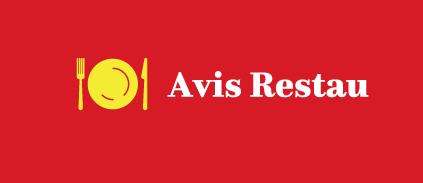

Data from : https://www.yelp.com/dataset

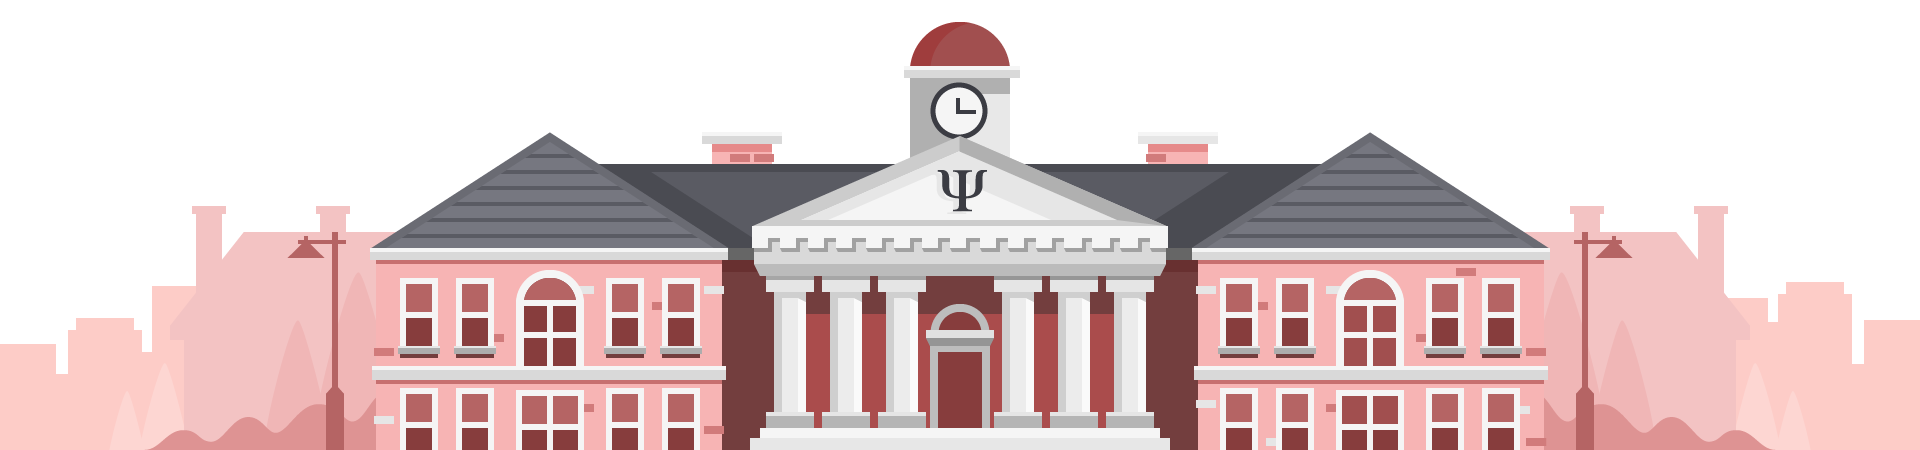

DATA:
+ 10 000 images.jpg de train
+ 1 000 images.jpg de test
+ 100 000 commentaires.json

In [1]:
# to use google drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#drive.flush_and_unmount

In [3]:
base_path = '/content/drive/MyDrive/JUJUPYTER/OpenClassrooms projects/P6/'

## Import

In [4]:
pip install pyLDAvis

In [5]:
pip install -U opencv-python

In [6]:
import json
import pandas as pd
import numpy as np

In [7]:
from PIL import Image
import glob
import os

In [8]:
from random import randrange
import cv2

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [11]:
#import pyLDAvis
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Functions

### Fonctions commentaires

In [12]:
def exemple_lda(idx):
  print(comments_usefull8[idx])
  list_topic_attribution = lda.transform(bag_of_words[idx])
  max_index_row = np.argmax(list_topic_attribution, axis=1)
  max_value_row = np.max(list_topic_attribution, axis=1)
  print("this comment is near the topic \""+str(max_index_row)+"\" with probability of \""+str(max_value_row)+"\"")

In [13]:
def plot_topics(words,components):
  for comp in components:
    df_plot = pd.DataFrame(words,comp).sort_index().tail(10)
    #display(df_plot)
    # plot
    df_plot["freq"] = df_plot.index
    df_plot["words"] = df_plot[0]
    sns.barplot(data=df_plot, y="freq", x="words")
    plt.show()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [14]:
def topic_top_words(encoding_matrix, topic_label = "topic1", nb_words=50):
  res = encoding_matrix.sort_values(topic_label).tail(nb_words)
  return res["mots"]

def display_wordcloud(list_wordcloud, nb_topics = 10):
    fig = plt.figure(figsize=[18,12],tight_layout=True)
    i = 1
    nb_lines = (nb_topics-1)//5+1
    for wc in list_wordcloud:
        plt.subplot(nb_lines, 5, i).set_title("Topic #" + str(i))
        plt.plot()
        plt.imshow(wc)
        plt.axis("off")
        i += 1
    fig.suptitle("Topic's top words")
    plt.show()

### Fonctions images

In [15]:
def apply_fun_2_folders(func, folders = ['drink','food','interior','outside','menu'], nb_res_func = 1, len_each_folder = 1000, base_path = base_path+'data/yelp_photos/train/'):
  res = []
  res2 = []
  if nb_res_func == 1:
    for classe in folders:
      func_return = func(base_path+classe+'/*.jpg', len=len_each_folder)
      res.append(func_return)
    res_unested = [item for sublist in res for item in sublist]
    return res_unested
  elif nb_res_func == 2:
    for classe in folders:
      func_return1,func_return2 = func(base_path+classe+'/*.jpg', len=len_each_folder)
      res.append(func_return1)
      res2.append(func_return2)
    res_unested = [item for sublist in res for item in sublist]
    res2_unested = [item for sublist in res2 for item in sublist]
    return res_unested,res2_unested
  else: print("error no > 2 returns values for func"); return 0

In [16]:
def order_img_file(pathInput,pathOutput,list_fileName_class):
  #assuming jpg
  #create folders with class names before
  for filename in glob.glob(pathInput): 
    imgID = os.path.basename(os.path.splitext(filename)[0])
    #print(imgID)
    #print(list_fileName_class[list_fileName_class["photo_id"] == imgID])
    if len(list_fileName_class[list_fileName_class["photo_id"] == imgID]) != 0:
      imgLABEL = list_fileName_class[list_fileName_class["photo_id"] == imgID]["label"].values[0]
      os.replace(filename, pathOutput+imgLABEL+"/"+imgID+".jpg")
    else: print("Error for file: "+imgID)

In [17]:
def read_img_and_get_labels(path,len = 1000):
  # df = dictionary file_name <=> class
  image_list = []
  list_img_labels = []
  i = 0
  for filename in glob.glob(path): #assuming jpg
    im=Image.open(filename)
    
    imgID = os.path.basename(os.path.splitext(filename)[0])
    #print(imgID)
    #print(df[df["photo_id"] == imgID].shape[0])
    if df[df["photo_id"] == imgID].shape[0] != 0:
      imgLABEL = df[df["photo_id"] == imgID]["label"].values[0]
      list_img_labels.append(imgLABEL)
      image_list.append(im)
    else: print("Error for file: "+imgID)
    i += 1
    if i >= len: break
  return image_list,list_img_labels
  
def read_img_to_GRAY(path, len = 1000):
  # df = dictionary file_name <=> class
  list_img_gray = []
  i = 0
  for filename in glob.glob(path): #assuming jpg
    rgb_l = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
    imgID = os.path.basename(os.path.splitext(filename)[0])
    if df[df["photo_id"] == imgID].shape[0] != 0:
      list_img_gray.append(gray_l)
    else: print("Error for file: "+imgID)
    i += 1
    if i >= len: break
  return list_img_gray

def img_to_SIFTdescriptor(list_img_gray):
  feature_extractor = cv2.SIFT_create(200)
  #feature_extractor = cv2.xfeatures2d.SIFT_create()
  list_img_descriptor = []
  list_img_keyP = []
  for img in list_img_gray:
    keypoint, descriptor = feature_extractor.detectAndCompute(img, None)
    list_img_descriptor.append(descriptor)
    list_img_keyP.append(keypoint)
  return list_img_keyP,list_img_descriptor

def SIFTdescriptor_to_centroid(list_descriptor, model):
  # model = kmeans model on all SIFT descriptors
  list_img_centroid = []
  for img in list_descriptor:
    list_centroid = []
    for descriptor in img:
      centroid = model.predict([descriptor])
      list_centroid.append(centroid)
    list_img_centroid.append(list_centroid)
  return list_img_centroid

def SIFTcentroid_to_hist(list_img_centroid):
  list_img_hist = []
  for img in list_img_centroid:
    count_visw = []
    for visual_word in range(nb_visual_word):
      count_visw.append(img.count(visual_word))
    list_img_hist.append(count_visw)
  return list_img_hist

## Analyse de commentaires

In [18]:
filename = base_path+'data/yelp_academic_dataset_review.json'
datas = []
nb_line = 100000
i=0
for line in open(filename):
  i+=1
  #print(line)
  if i > nb_line: break
  data = json.loads(line)
  datas.append(data)
  
df = pd.DataFrame(datas)

In [19]:
df.head(10)

review_id  ...                 date
0  lWC-xP3rd6obsecCYsGZRg  ...  2014-10-11 03:34:02
1  8bFej1QE5LXp4O05qjGqXA  ...  2015-07-03 20:38:25
2  NDhkzczKjLshODbqDoNLSg  ...  2013-05-28 20:38:06
3  T5fAqjjFooT4V0OeZyuk1w  ...  2010-01-08 02:29:15
4  sjm_uUcQVxab_EeLCqsYLg  ...  2011-07-28 18:05:01
5  J4a2TuhDasjn2k3wWtHZnQ  ...  2018-01-21 04:41:03
6  28gGfkLs3igtjVy61lh77Q  ...  2006-04-16 02:58:44
7  9vqwvFCBG3FBiHGmOHMmiA  ...  2017-12-02 18:16:13
8  2l_TDrQ7p-5tANOyiOlkLQ  ...  2012-05-28 15:00:47
9  KKVFopqzcVfcubIBxmIjVA  ...  2014-05-07 18:10:21

[10 rows x 9 columns]

Detecter les sujets d'**insatisfaction**

In [20]:
mask1 = df["useful"] > 1
mask2 = df["stars"] < 4

In [21]:
df_usefull = df[mask1 & mask2]
comments_usefull = df_usefull["text"]

In [22]:
len(comments_usefull)

8374

In [23]:
comments_usefull.head(10)

5     This place used to be a cool, chill place. Now...
11    Disappointing. Bolt is a follow up of Fanny's ...
26    When we first arrived at the Coco Key, we were...
34    "A Bit Embarrassed"\n\nI'm not exactly sure wh...
41    I wanted this to be a great place, but I wasn'...
46    Bummer. I was very disappointed.  So I finally...
58    Overall can be a great experience if you're a ...
66    So my roommate borrowed my clock radio and app...
75    If this isn't your first time at the specialty...
77    If service is any indication, then I'm never g...
Name: text, dtype: object

### Bags of words

#### Pre-traitement

texte => sans ponctuation

In [24]:
comments_usefull2 = comments_usefull.map(lambda x: re.sub('[,\".!?(;)]', '', x))

texte => en minuscule

In [25]:
comments_usefull3 = comments_usefull2.map(lambda x: x.lower())

texte => remplace "\n"

In [26]:
comments_usefull4 = comments_usefull3.map(lambda x: x.replace('\n', ' '))

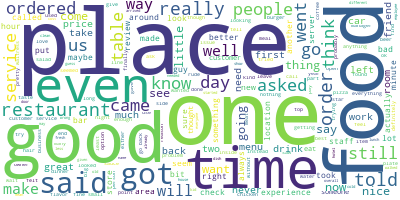

In [27]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(comments_usefull4)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

#### Tokenisation

texte => tokens

In [28]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [29]:
comments_usefull5 = [nltk.word_tokenize(comment) for comment in comments_usefull4]

#### lemmatisation (tokens => lemme)

+ **Lemmatisation** = remplace le mot par sa forme la plus simple (pour le français infinitif/masculin-singulier)
+ Stematisation = garder la racine du mot (enlever une partie de la fin du terme)

On utilise la base de données **wordnet** pour la lemmatisation

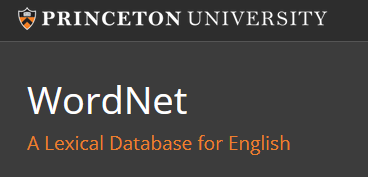

In [30]:
lemmatizer = WordNetLemmatizer()

In [31]:
comments_usefull6 = []
for comment in comments_usefull5:
  comments_usefull6.append([lemmatizer.lemmatize(word) for word in comment])

keep only english word and number

In [32]:
words = set(nltk.corpus.words.words())

Elimination des mots inutiles observés dans les topics (après execution).

In [33]:
words.remove("wa")
# Washington = "wa" ?
words.remove("did")
# did =/=> do ?

In [34]:
comments_usefull7 = []
for comment in comments_usefull6:
  comments_usefull7.append([word for word in comment if word.lower() in words or not word.isalpha()])

In [35]:
comments_usefull8 = []
for comment in comments_usefull7:
  comments_usefull8.append(' '.join(comment))

#### TF-IDF

comptage des mots

On prend en compte la frequence d'apparition des mots dans tous les commentaires

In [36]:
# ignore words that appear in less than 3 in the comments
vectorizer = TfidfVectorizer(min_df=3, stop_words='english', max_features=1000)
bag_of_words = vectorizer.fit_transform(comments_usefull8)


#### Exemple

exemple sur le 1er commentaire

In [37]:
comments_usefull8[0]

'this place used to be a cool chill place now it a bunch of bouncer hopped up on steroid acting like the can do whatever they want there are so many better place in square where they are glad you are visiting their business sad that the is now the worst place in'

In [38]:
exemple1 = bag_of_words[0].toarray()[0]

In [39]:
features_array = np.array(vectorizer.get_feature_names())

mots gardés 

In [40]:
features_array[exemple1 != 0]

array(['better', 'bunch', 'business', 'cool', 'glad', 'like', 'place',
       'sad', 'square', 'used', 'want', 'worst'], dtype='<U14')

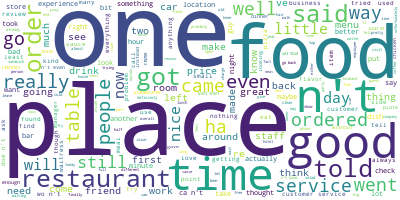

In [41]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(comments_usefull8)# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

Pour la **segmentation** des commentaire on utilisera **LDA** et **LSA**.\
NMF = Works best with shorter texts such as tweets or titles.

### LSA (Latent Semantic Analysis)

Plus stable que LDA ?

+ lack of interpretable embeddings (we don’t know what the topics are, and the components may be arbitrarily positive/negative)
+ need for really large set of documents and vocabulary to get accurate results
+ less efficient representation

On créé 2 composantes pour visualiser les commentaires sous formes de vecteur en 2D (similaire à une PCA)

In [42]:
svd = TruncatedSVD(n_components=10)
lsa = svd.fit_transform(bag_of_words)

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [43]:
topic_labels = ["topic"+str(i+1) for i in range(10)]

In [44]:
topics_tfidf_df = pd.DataFrame(lsa, columns = topic_labels)

In [45]:
topics_tfidf_df["comments"] = comments_usefull8

In [46]:
encoding_matrix = pd.DataFrame(svd.components_, index = topic_labels).T
encoding_matrix["mots"] = vectorizer.get_feature_names()

In [47]:
df_topics_lsa = pd.DataFrame(columns=topic_labels)
list_wordcloud = []
for i in range(10):
  res = topic_top_words(encoding_matrix, topic_label = "topic"+str(i+1))
  df_topics_lsa["topic"+str(i+1)] = res
  #print(res)
  #display(res)
  long_string = ','.join(res)# Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')# Generate a word cloud
  wordcloud.generate(long_string)# Visualize the word cloud
  list_wordcloud.append(wordcloud.to_image())

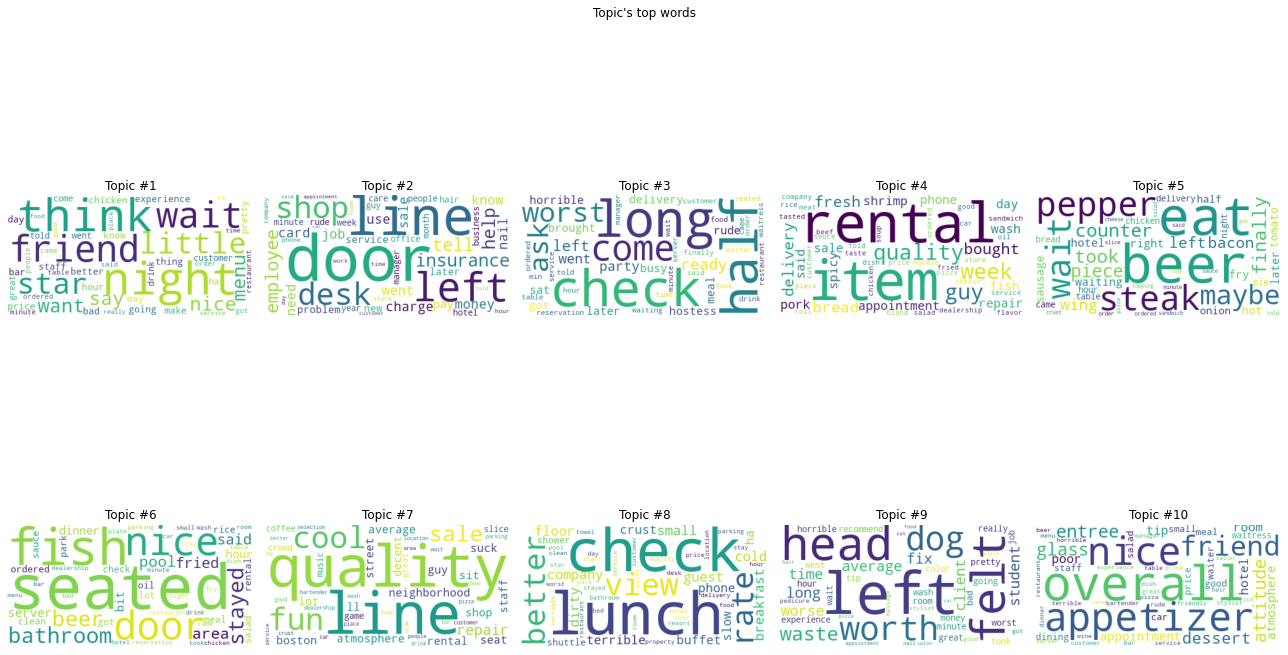

In [48]:
display_wordcloud(list_wordcloud)

In [49]:
res = []
for n_comp in [2,10,20,50,100,200,500]:
  svd2 = TruncatedSVD(n_components=n_comp)
  lsa2 = svd2.fit_transform(bag_of_words)
  res.append(svd2.explained_variance_ratio_.sum())

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

[Text(0.5, 1.0, 'variance explained for differents number of component')]

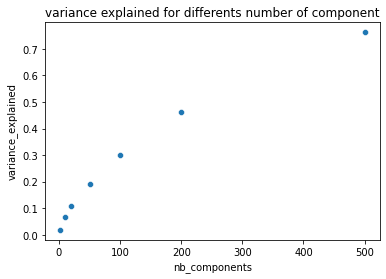

In [50]:
df_plot = pd.DataFrame({"nb_components":[2,10,20,50,100,200,500],"variance_explained":res})

sns.scatterplot(data=df_plot, x="nb_components", y="variance_explained").set(title='variance explained for differents number of component')

**Remarque:** L'augmentation de la variance expliqué est non linéaire en fonction du nombre de composante fixé

On a une faible explication de la variance avec LSA (ce n'est pas grave car tout les mots ne sont pas important pour classifier les commentaires) 
+ avec 2 composantes : **2%**
+ avec 10 composantes : **7%**

In [51]:
import matplotlib.pyplot as plt

In [52]:
tmp = encoding_matrix.sort_values("topic2").tail(10)
tmp2 = encoding_matrix.sort_values("topic1").tail(10)
data_plt = tmp.append(tmp2)

In [53]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], str(point['val']))
    return ax

In [54]:
data_plt["related_to"] = "topic1"
i = 0
for line in data_plt.iterrows():
  if i < 10: data_plt["related_to"].iloc[i] = "topic2"
  i += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


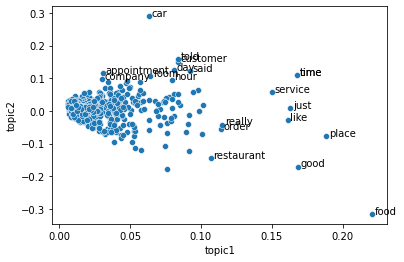

In [55]:
ax = sns.scatterplot(data=encoding_matrix, x="topic1", y="topic2")
ax = label_point(data_plt.topic1, data_plt.topic2, data_plt.mots, ax)
plt.show()

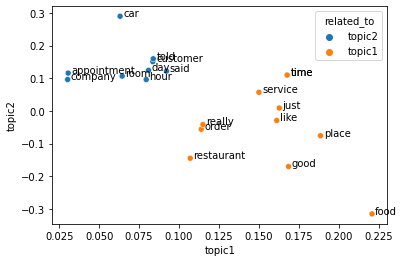

In [56]:
ax = sns.scatterplot(data=data_plt, x="topic1", y="topic2", hue="related_to")
ax = label_point(data_plt.topic1, data_plt.topic2, data_plt.mots, ax)
plt.show()

### LDA segmentation

 LDA does not directly output document similarities

Utilisation de LDA pour créer des topics. Après differents essais (LDA = non déterministe), 10 topics semblent etre apropriés pour décrire la plupart des differents sujets des commentaires.

In [57]:
from sklearn.decomposition import LatentDirichletAllocation

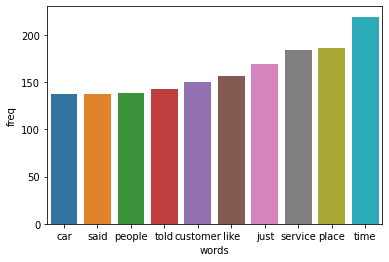

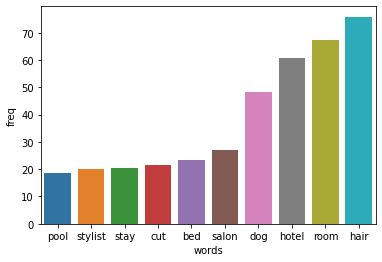

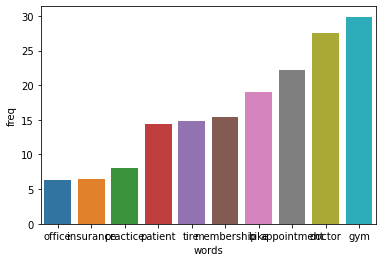

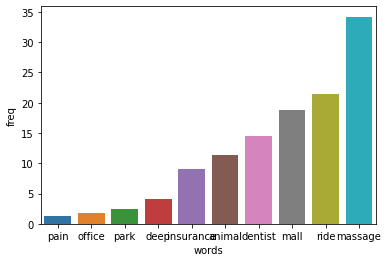

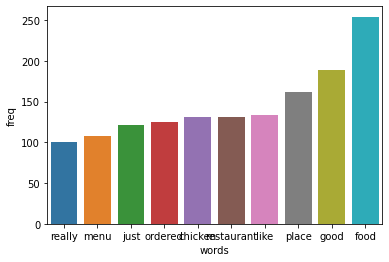

In [58]:
n_topics = 5

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

lda.fit(bag_of_words)
plot_topics(vectorizer.get_feature_names(),lda.components_)

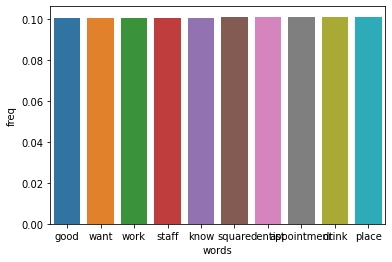

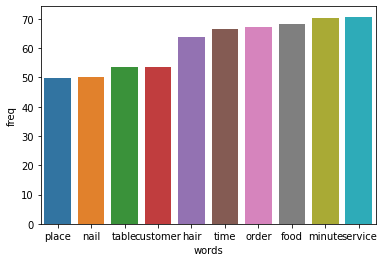

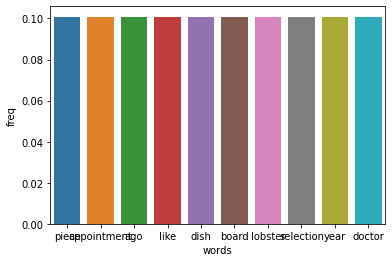

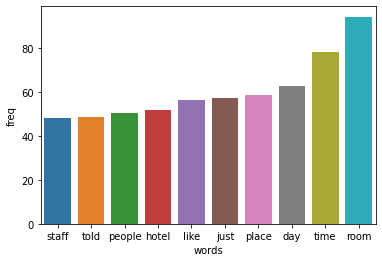

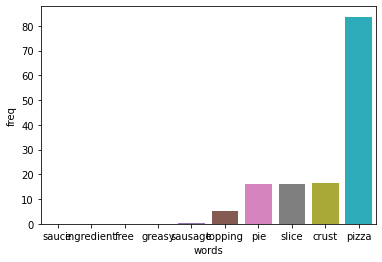

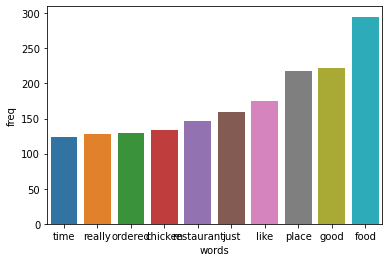

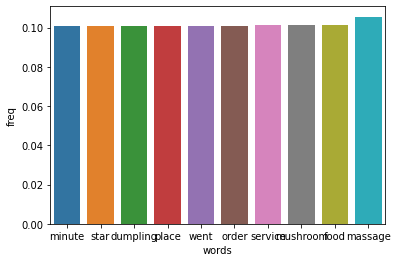

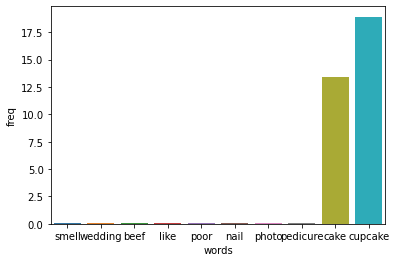

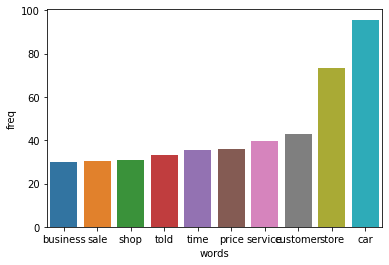

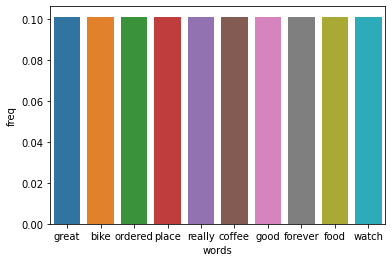

In [59]:
n_topics = 10

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

lda.fit(bag_of_words)
#display_topics(lda, vectorizer.get_feature_names(), 10)
plot_topics(vectorizer.get_feature_names(),lda.components_)

**Remarque:** On peut observer certains sujet de topic, par exemple:
+ voiture
+ gateau
+ pedicure
+ massage
+ chambre hotel
+ nourriture
+ coiffure
+ velo
+ habit
+ attente




**Remarque:** Les topics varie pour chaque execution.\
 Certains topic regroupe un même champ lexical, on peut leurs attribuer un sens

#### Visu (pyldavis)

In [60]:
pyLDAvis.enable_notebook()

In [61]:
pyLDAvis.sklearn.prepare(lda, bag_of_words, vectorizer)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.033027 -0.027303       1        1  43.370128
3      0.074325  0.033635       2        1  21.452331
1      0.110134  0.053340       3        1  14.812205
8      0.106833  0.067302       4        1  10.463406
4     -0.246599  0.075212       5        1   1.862731
7     -0.023278 -0.117147       6        1   1.661063
0     -0.013590 -0.021238       7        1   1.594534
6     -0.013594 -0.021242       8        1   1.594534
9     -0.013623 -0.021266       9        1   1.594534
2     -0.013635 -0.021293      10        1   1.594534, topic_info=        Term        Freq       Total Category  logprob  loglift
635    pizza  310.000000  310.000000  Default  30.0000  30.0000
217  cupcake  106.000000  106.000000  Default  29.0000  29.0000
128     cake  100.000000  100.000000  Default  28.0000  28.0000
795    slice   74.000000   74.000000  Default  27.0000  27.0000
633      pie   64.000000   64.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
595  ordered    0.694790  140.719666  Topic10  -6.9050  -1.1723
897     told    0.694743  151.136739  Topic10  -6.9051  -1.2438
379      got    0.694743  171.288257  Topic10  -6.9051  -1.3690
636    place    0.694736  311.527298  Topic10  -6.9051  -1.9671
785  similar    0.694626   23.251787  Topic10  -6.9052   0.6278

[700 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4         1  0.297492    15
4         2  0.202835    15
4         3  0.365104    15
4         4  0.081134    15
4         6  0.013522    15
...     ...       ...   ...
994       6  0.009724  year
994       7  0.009724  year
994       8  0.009724  year
994       9  0.009724  year
994      10  0.009724  year

[2858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 9, 5, 8, 1, 7, 10, 3])

**Remarque:** 
+ Plus un cercle est gros, plus le topic qu'il represente est populaire
+ Plus les cercle sont eloignés, plus les topics qu'ils representent sont differents
+ λ faible = visualisation des mots specifique au topic selectionné
+ λ fort = visualisation des mots les plus frequent dans le topic selectionné


#### Exemple

In [62]:
exemple_lda(2)

when we first at the coco key we were by a number of staff member a we checked in the process slightly awkward because the staff new or in training which can happen from time to time no harm no foul the foul part came when we our room the carpet soggy near the bathroom and the entire room with a musty smell something along the line of aeu-de-someone-flooded-the-toilet after -- which i should n't have done but i 'm a sucker for any opportunity for sticking thing out and making them work we the front desk shortly thereafter a housekeeper with a spray bottle to investigate she agreed that the carpet to be which would happen the following day and what i can only assume to be anti-mold stuff i n't ask -- which clearly you can see from this point mean i have some sort of timidness for communication i really need to outgrow that long story short by the time she had hosed down the carpet wall and doorway with her spray bottle we were left and choking on the fume and were forced to spend the ni

## Analyse de photos

In [63]:
filename = base_path+'data/yelp_photos/photos.json'

In [64]:
datas = []
for line in open(filename):
  data = json.loads(line)
  datas.append(data)
  
df = pd.DataFrame(datas)

In [65]:
df.describe()

photo_id             business_id caption   label
count                   200000                  200000  200000  200000
unique                  199999                   39438   86333       5
top     luJ6-yFuJCZzjUYDQu9Dhw  4CxF8c3MB7VAdY8zFb2cZQ           drink
freq                         2                     493   88090   40000

In [66]:
df.head(5)

photo_id  ...  label
0  Un_Og6jfhazVn7CxszkKEw  ...  drink
1  BFE1AFOs27scnnfeBf99ZA  ...  drink
2  7t-C0r1JRdoVD9FS7M-N7Q  ...  drink
3  rLnw0d-YYZvT9kR4y7h7_Q  ...  drink
4  Cv5M8MDw8a5NEWvw2AQ4nw  ...  drink

[5 rows x 4 columns]

In [67]:
df["label"].unique()

array(['drink', 'food', 'interior', 'outside', 'menu'], dtype=object)

**Remarque:** On a 5 types de photos; 'drink', 'food', 'interior', 'outside', 'menu'

### trier data

On range les images dans des dossiers (créés auparavant) avec le nom de leurs classes

In [68]:
pathInput = base_path+'data/yelp_photos/train/*.jpg'
pathOutput = base_path+'data/yelp_photos/train/'
order_img_file(pathInput,pathOutput,df)

In [69]:
pathInput = base_path+'data/yelp_photos/test/*.jpg'
pathOutput = base_path+'data/yelp_photos/test/'
order_img_file(pathInput,pathOutput,df)

### Descripteurs SIFT

(voir https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f pour explication)

In [70]:
# load 200 images of each class
image_list,list_img_labels = apply_fun_2_folders(read_img_and_get_labels,nb_res_func=2)

In [71]:
list_img_gray = apply_fun_2_folders(read_img_to_GRAY,nb_res_func=1)

In [72]:
from random import shuffle

In [73]:
# shuffle to keep same number of class in subset (for later)
abc = list(zip(image_list, list_img_labels, list_img_gray))

shuffle(abc)

image_list, list_img_labels, list_img_gray = zip(*abc)


food


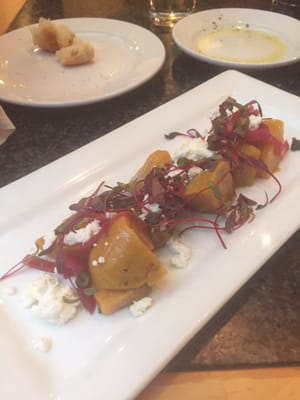

In [74]:
idx = randrange(0,2000)
print(list_img_labels[idx])
image_list[idx]

In [75]:
list_img_keyP,list_img_descriptor = img_to_SIFTdescriptor(list_img_gray)

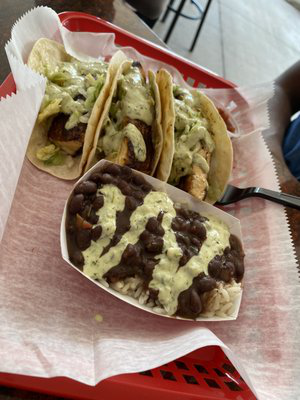

In [76]:
image_list[0]

Dimensions des descripteurs 128


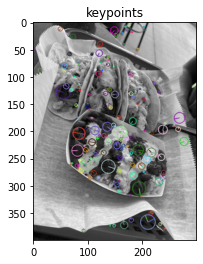

In [77]:
test = cv2.drawKeypoints(list_img_gray[0], list_img_keyP[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("Dimensions des descripteurs "+str(len(list_img_descriptor[0][1])))
plt.imshow(test)
plt.title("keypoints")
plt.show()

**Remarque:** Les descripteurs SIFT de la 1er image (zoomer pour voir le cercle) :

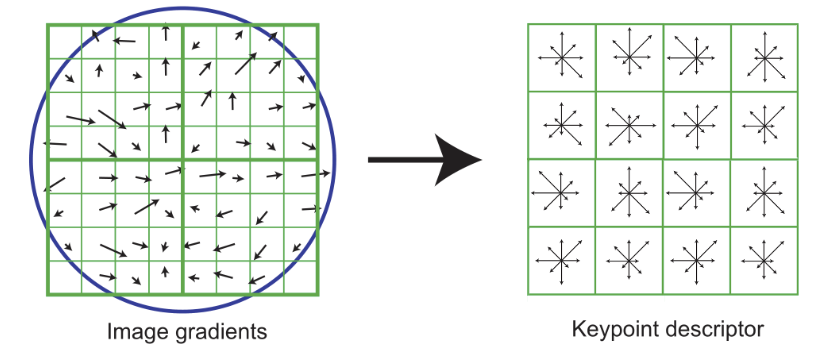

#### Bag of features (K-means)

segmentation des descripteurs SIFT. On regroupe les descripteurs semblables avec un K-means

In [78]:
from sklearn.cluster import KMeans


In [79]:
flat_list = [item for sublist in list_img_descriptor for item in sublist]

In [80]:
len(flat_list)

994148

On limite le nombre de descripteur à 1 000 000 pour former les centroids (bag of words).

*50 min*




In [81]:
flat_list_light = flat_list[:1000000]

In [82]:
print("OK")

OK


In [83]:
from sklearn.cluster import MiniBatchKMeans

In [84]:
nb_visual_word = 60
# 10 * nb_class <= nb_visual_word <= sqrt(nb_sift)
#      50       <= nb_visual_word <=     1000
# https://datascience.stackexchange.com/questions/16143/what-is-the-procedure-to-create-a-bag-of-visual-words-model-with-sift
# https://register.gotowebinar.com/recording/5532038138285671435

In [85]:
kmeans = MiniBatchKMeans(n_clusters=nb_visual_word,
                         random_state=0).fit(flat_list_light)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` 

In [86]:
#kmeans = KMeans(n_clusters=nb_visual_word, random_state=0).fit(flat_list_light)


In [87]:
print("OK")

OK


In [88]:
visual_words = kmeans.cluster_centers_

In [89]:
print("OK")

OK


On créé nos nouvelles données en remplaçant les descripteur SIFT par leurs centroide proche

In [90]:
# todo prend = 38min

In [91]:
list_img_centroid = SIFTdescriptor_to_centroid(list_img_descriptor, model = kmeans)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` 

In [92]:
print("OK")

OK


In [93]:
#2h20

Création d'un histogramme/dictionnaire pour compter le nombre de chaque visual word dans chaque image

In [94]:
list_img_hist = SIFTcentroid_to_hist(list_img_centroid)

**Exemples**

In [95]:
def display_img_hist(idx):
  sns.scatterplot(data=list_img_hist[idx])
  plt.title('Freq of each visual words')
  plt.xlabel('visual word ID')
  plt.ylabel('number of each')
  plt.show()

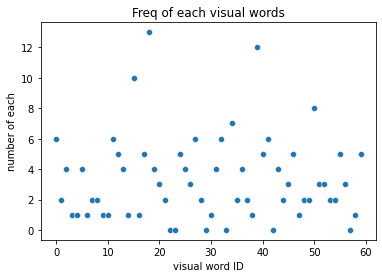

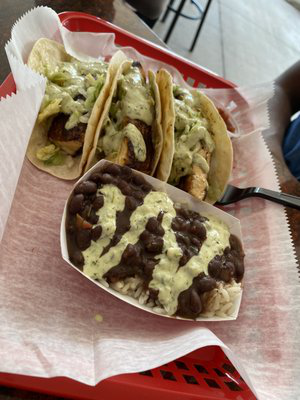

In [96]:
display_img_hist(0)
image_list[0]

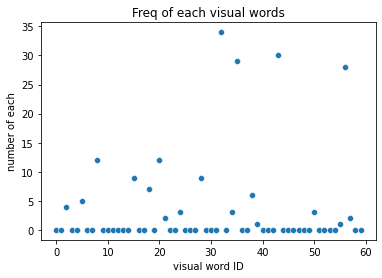

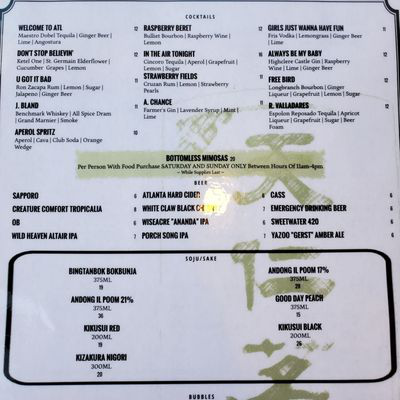

In [97]:
display_img_hist(1)
image_list[1]

Les images sont maintenant caracterisées par un histogramme, on peut utiliser des algorithmes de **classification** sur ces données.

In [98]:
image_list_test,list_img_labels_test = read_img_and_get_labels(base_path+'data/yelp_photos/test/*/*.jpg')

In [99]:
list_img_gray_test = read_img_to_GRAY(base_path+'data/yelp_photos/test/*/*.jpg')


In [100]:
list_img_keyP_test,list_img_descriptor_test = img_to_SIFTdescriptor(list_img_gray_test)


In [101]:
list_img_centroid_test = SIFTdescriptor_to_centroid(list_img_descriptor_test, model = kmeans)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` 

In [102]:
list_img_hist_test = SIFTcentroid_to_hist(list_img_centroid_test)

In [103]:
len(list_img_hist_test)

1000

In [104]:
len(list_img_hist)

5000

#### Visu des images (PCA => t-SNE)

In [105]:
print("ok")

ok


In [106]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
pca.fit(list_img_hist)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.2587465  0.08852281 0.08093781 0.06270026 0.04963198 0.03962642
 0.03167374 0.03023778 0.02605234 0.02422376 0.021045   0.01859508
 0.01715106 0.015882   0.01460336 0.01407053 0.0120143  0.01036193
 0.00976542 0.00903002 0.00871036 0.00796383 0.00785262 0.00680615
 0.00668651 0.00651293 0.00599703 0.00584907 0.00573426 0.00535487
 0.00514582 0.0049961  0.00476082 0.0043883  0.0043202  0.00416539
 0.00404356 0.00399359 0.00383256 0.0036244  0.00343207 0.00336623
 0.00327018 0.00312034 0.00308877 0.00304689 0.00294298 0.00290359
 0.00285972 0.00279818 0.0027775  0.00268444 0.00266119 0.00260537
 0.00256958 0.00236699]
[1179.85544504  690.11134191  659.88351503  580.79951476  516.74034345
  461.72565039  412.80144387  403.33557281  374.38194391  361.00423762
  336.48524258  316.29377067  303.76450188  292.31035833  280.29663944
  275.13558313  254.23823411  236.10860152  229.21185198  220.41239159
  216.47597435  206.99156256  205.54114861  191.35609521  189.66682256
  187.18878981  17

In [107]:
list_img_hist_reduced = pca.fit_transform(list_img_hist)

In [108]:
print("On passe de "+str(len(list_img_hist[0]))+" dimensions à "+str(len(list_img_hist_reduced[0]))+" avec PCA (en gardant 99% de la variance)")

On passe de 60 dimensions à 56 avec PCA (en gardant 99% de la variance)


In [109]:
import numpy as np
from sklearn.manifold import TSNE
# doc: perplexity = Consider selecting a value between 5 and 50
list_img_hist_reduced2 = TSNE(n_components=2, perplexity=50).fit_transform(list_img_hist_reduced)
list_img_hist_reduced2.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/

(5000, 2)

In [110]:
df_img_vis = pd.DataFrame()

df_img_vis['PC1'] = list_img_hist_reduced2[:,0]
df_img_vis['PC2'] = list_img_hist_reduced2[:,1] 
df_img_vis['label'] = list_img_labels


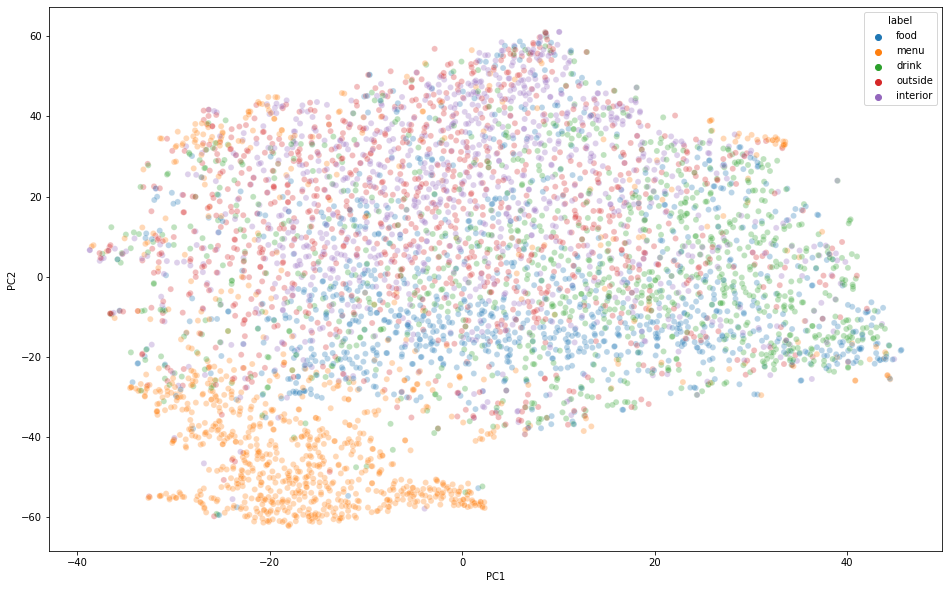

In [111]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="label",
    data=df_img_vis,
    legend="full",
    alpha=0.3
)

**Remarque:** Les histogrammes des images représentés sur 2 dimensions. **Les images de type "menu" se distinguent** par rapport aux autres classes, on retrouve la même tendance dans les resultats qui suivent (en classification).

**Segmentation des données** (kmeans) sans les labels pour voir si on retrouve des points communs entre cette segmetation et la repartition des images en fonction de leur labels.

In [112]:
kmeans_vis = MiniBatchKMeans(n_clusters=5,random_state=0).fit(list_img_hist)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

In [113]:
df_img_vis2 = pd.DataFrame()

df_img_vis2['PC1'] = list_img_hist_reduced2[:,0]
df_img_vis2['PC2'] = list_img_hist_reduced2[:,1] 
df_img_vis2['label'] = kmeans_vis.labels_


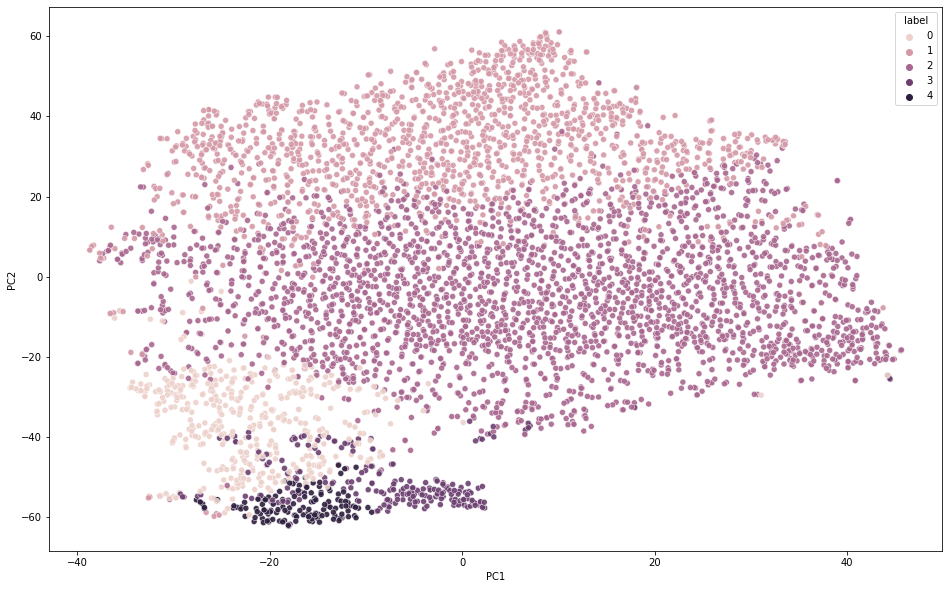

In [114]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="label",
    data=df_img_vis2,
    legend="full",
    alpha=0.9
)

**Remarque:** La classe "0" calculée par segmentation englobe une majorité d'image de classe "menu". 

In [115]:
from sklearn.metrics import adjusted_rand_score

In [116]:
y_kmeans_w_labels = df_img_vis2['label'].replace(0,"menu").replace(1,"drink").replace(2,"outside").replace(3,"interior").replace(4,"food")

In [117]:
adjusted_rand_score(df_img_vis['label'], y_kmeans_w_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:124: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


0.10207163771618182

In [120]:
print(confusion_matrix(df_img_vis['label'], y_kmeans_w_labels, labels=['drink', 'food', 'interior', 'outside', 'menu']))

[[220   1   8 745  26]
 [157   2   3 806  32]
 [542   0   1 445  12]
 [459   0   1 516  24]
 [147 136 215 144 358]]


#### Classification (Knn)

In [121]:
X_train = list_img_hist
y_train = list_img_labels
X_test = list_img_hist_test
y_test = list_img_labels_test

In [122]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:1142: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [123]:
y_pred = neigh.predict(X_test)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)


In [124]:
accuracy_score(y_pred, y_test)

0.466

In [125]:
print(confusion_matrix(y_test, y_pred, labels=['drink', 'food', 'interior', 'outside', 'menu']))

[[ 83  40  41  41   5]
 [ 38  93  16  28   4]
 [ 37  25  90  47   6]
 [ 40  30  72  61  11]
 [ 20  13  12   8 139]]


**Remarque:** Une bonne prediction des images de menu (derniere colonne/ligne).\
Mais globalement une mauvaise prediction

In [126]:
index = randrange(0,99)

In [127]:
print("predict:")
pred = neigh.predict([list_img_hist_test[index]])[0]
print(pred)
print("True class:")
true_class = list_img_labels_test[index]
print(true_class)
if true_class != pred: print("miss classification!")

predict:
outside
True class:
drink
miss classification!


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)


#### Classification (Xgboost)

In [128]:
from sklearn.svm import SVC
import xgboost as xgb


In [129]:
#xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(np.asarray(X_train), np.asarray(y_train))

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred, labels=['drink', 'food', 'interior', 'outside', 'menu']))
print('Accuracy Score:')
print(accuracy_score(y_pred, y_test))

[[102  34  35  34   5]
 [ 19 136  13   8   3]
 [ 25  22 101  49   8]
 [ 26  19  63  89  17]
 [ 10   4   5  13 160]]
Accuracy Score:
0.588


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:391: DeprecationWarning: Initializing DMatrix from List is deprecated.
  DeprecationWarning)


#### Classification (SVC)

In [130]:
from sklearn.svm import SVC
from sklearn import metrics
svc=SVC() #Default hyperparameters
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=['drink', 'food', 'interior', 'outside', 'menu']))
print('Accuracy Score:')
print(metrics.accuracy_score(y_test,y_pred))

[[106  32  36  28   8]
 [ 26 133   5  14   1]
 [ 21  21 106  49   8]
 [ 19  15  67  99  14]
 [ 10   7   2   7 166]]
Accuracy Score:
0.61


**Remarque:** *Accuracy score*
+ Knn:\
(2000 photos) 0.522 % => (5000 photos) 0.529 %
+ Xgboost:\
(2000 photos) 0.613 % => (5000 photos) 0.628 %
+ SVC:\
(2000 photos) 0.633 % => (5000 photos)  0.66 %


### preparation data

On utilise les images en **couleur** pour cette partie

80% train 20% test

In [131]:
import glob
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by its

In [132]:
from keras.layers import Dense,Dropout,Flatten
from keras import Model
from keras.applications.vgg16 import VGG16
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix


In [133]:
import numpy as np

In [134]:
# For training set onlyimport globangry = glob.glob('/content/drive/My_Drive/train_logmel/angry/*.*')
food = glob.glob(base_path+'data/yelp_photos/train/food/*')
interior = glob.glob(base_path+'data/yelp_photos/train/interior/*')
outside = glob.glob(base_path+'data/yelp_photos/train/outside/*')
drink = glob.glob(base_path+'data/yelp_photos/train/drink/*')
menu = glob.glob(base_path+'data/yelp_photos/train/menu/*')

data = []
labels = []

for i in food:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('food')
print("1/5")
for i in interior:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('interior')
print("2/5")
for i in outside:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('outside')
print("3/5")
for i in drink:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('drink')
print("4/5")
for i in menu:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('menu')


train_data = np.array(data)
train_labels = np.array(labels)

1/5
2/5
3/5
4/5


In [135]:
X_train = train_data[0:1600]
X_train = np.append(X_train,train_data[2000:3600], axis=0)
X_train = np.append(X_train,train_data[4000:5600], axis=0)
X_train = np.append(X_train,train_data[6000:7600], axis=0)
X_train = np.append(X_train,train_data[8000:9600], axis=0)

X_test = train_data[1600:2000]
X_test = np.append(X_test,train_data[3600:4000], axis=0)
X_test = np.append(X_test,train_data[5600:6000], axis=0)
X_test = np.append(X_test,train_data[7600:8000], axis=0)
X_test = np.append(X_test,train_data[9600:], axis=0)

y_train = train_labels[0:1600]
y_train = np.append(y_train,train_labels[2000:3600])
y_train = np.append(y_train,train_labels[4000:5600])
y_train = np.append(y_train,train_labels[6000:7600])
y_train = np.append(y_train,train_labels[8000:9600])

y_test = train_labels[1600:2000]
y_test = np.append(y_test,train_labels[3600:4000])
y_test = np.append(y_test,train_labels[5600:6000])
y_test = np.append(y_test,train_labels[7600:8000])
y_test = np.append(y_test,train_labels[9600:])


In [136]:
# todo """ ... """
X_train = train_data[0:10]
X_train = np.append(X_train,train_data[2025:2035], axis=0)
X_train = np.append(X_train,train_data[3990:4000], axis=0)
X_train = np.append(X_train,train_data[6600:6610], axis=0)
X_train = np.append(X_train,train_data[9990:], axis=0)

X_test = train_data[10:15]
X_test = np.append(X_test,train_data[2035:2040], axis=0)
X_test = np.append(X_test,train_data[4000:4005], axis=0)
X_test = np.append(X_test,train_data[6610:6615], axis=0)
X_test = np.append(X_test,train_data[9985:9990], axis=0)

y_train = train_labels[0:10]
y_train = np.append(y_train,train_labels[2025:2035])
y_train = np.append(y_train,train_labels[3990:4000])
y_train = np.append(y_train,train_labels[6600:6610])
y_train = np.append(y_train,train_labels[9990:])

y_test = train_labels[10:15]
y_test = np.append(y_test,train_labels[2035:2040])
y_test = np.append(y_test,train_labels[4000:4005])
y_test = np.append(y_test,train_labels[6610:6615])
y_test = np.append(y_test,train_labels[9985:9990])

In [137]:
"""print(train_labels[0:10])
print(train_labels[2025:2035])
print(train_labels[3990:4000])
print(train_labels[6600:6610])
print(train_labels[9990:])"""

'print(train_labels[0:10])\nprint(train_labels[2025:2035])\nprint(train_labels[3990:4000])\nprint(train_labels[6600:6610])\nprint(train_labels[9990:])'

In [138]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [139]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

On utilisera le CNN vgg16 pour un bon compromis temps/precision (voir https://keras.io/api/applications/)

### VGG16 (Random weights)

In [140]:
vgg_model = VGG16(weights=None,include_top=False, input_shape=(224, 224, 3))

In [141]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
#x = Dense(8, activation='softmax')(x) # Softmax for multiclass
x = Dense(5, activation='softmax')(x) # Softmax for multiclass
transfer_model_rand = Model(inputs=vgg_model.input, outputs=x)

In [142]:
transfer_model_rand.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [143]:
print("OK")

OK


In [144]:
learning_rate= 5e-5
transfer_model_rand.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
history = transfer_model_rand.fit(X_train, y_train, batch_size = 32, epochs=1, validation_data=(X_test,y_test))

2/2 [==============================] - 101s 44s/step - loss: 1.6096 - accuracy: 0.1600 - val_loss: 1.6094 - val_accuracy: 0.2400


In [145]:
print("OK")

OK


In [146]:
# predict the probability across all output classes
y_pred_probality = transfer_model_rand.predict(X_test)

y_pred_clean = np.argmax(y_pred_probality, axis=1)
y_test_clean = np.argmax(y_test, axis=1)

In [147]:
matrix_conf = confusion_matrix(y_test_clean, y_pred_clean, labels=[0,1,2,3,4])
pd.DataFrame(matrix_conf, columns=['Pred drink', 'Pred food', 'Pred interior', 'Pred outside', 'Pred menu'], index=['Tdrink', 'Tfood', 'Tinterior', 'Toutside', 'Tmenu'])

Pred drink  Pred food  Pred interior  Pred outside  Pred menu
Tdrink              1          0              0             4          0
Tfood               1          0              1             3          0
Tinterior           0          0              1             4          0
Toutside            0          0              1             4          0
Tmenu               0          0              0             5          0

### VGG16 (Pre-train weights)

In [148]:
vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [149]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
#x = Dense(8, activation='softmax')(x) # Softmax for multiclass
x = Dense(5, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [150]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [151]:
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history = transfer_model.fit(X_train, y_train, batch_size = 32, epochs=1, validation_data=(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


2/2 [==============================] - 100s 44s/step - loss: 1.6294 - accuracy: 0.2400 - val_loss: 1.4805 - val_accuracy: 0.3600


In [152]:
# predict the probability across all output classes
y_pred_probality = transfer_model.predict(X_test)

y_pred_clean = np.argmax(y_pred_probality, axis=1)
y_test_clean = np.argmax(y_test, axis=1)

In [153]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(y_test_clean, y_pred_clean, labels=[0,1,2,3,4])
pd.DataFrame(matrix_conf, columns=['Pred drink', 'Pred food', 'Pred interior', 'Pred outside', 'Pred menu'], index=['Tdrink', 'Tfood', 'Tinterior', 'Toutside', 'Tmenu'])

Pred drink  Pred food  Pred interior  Pred outside  Pred menu
Tdrink              1          0              2             0          2
Tfood               1          2              2             0          0
Tinterior           0          0              4             0          1
Toutside            0          0              2             1          2
Tmenu               0          0              4             0          1

## API (new data)

Recuperation de nouvelles données via l'API de yelp

In [154]:
import requests

In [155]:
api_key = '4dbyAT9W5PhiAEl_ZnkEYUYg0i-QpCuN4xC1WwI81MIk3RxwMhYWD5RuiijQNvQP5ruLVZZqbU7-VHtRJZo8bNoPnwSfUlpkYY2SzD9i_o2pu0ZcDtDQlHcoUb04YXYx'

In [156]:
headers = {'Authorization': 'Bearer {}'.format(api_key)}
search_api_url = 'https://api.yelp.com/v3/businesses/search'
params = {'term': 'coffee', 
          'location': 'Paris, France',#France, Paris
          'limit': 50}

In [157]:
# timeout of 5 seconds: https://requests.readthedocs.io/en/master/user/quickstart/#timeouts
response = requests.get(search_api_url, headers=headers, params=params, timeout=5)

In [158]:
print(response.url)
print(response.status_code)

https://api.yelp.com/v3/businesses/search?term=coffee&location=Paris%2C+France&limit=50
200


In [159]:
print(response.headers)

{'Connection': 'keep-alive', 'content-type': 'application/json', 'ratelimit-dailylimit': '5000', 'ratelimit-remaining': '5000', 'ratelimit-resettime': '2021-11-07T00:00:00+00:00', 'x-b3-sampled': '0', 'x-zipkin-id': '3789e0e17f755a29', 'server': 'envoy', 'x-routing-service': 'routing-main--useast1-b9c656cb7-2gmp4; site=public_api_v3', 'x-cloudmap': 'routing_useast1', 'content-encoding': 'gzip', 'x-proxied': '10-65-133-10-useast1bprod', 'x-extlb': '10-65-133-10-useast1bprod', 'cache-control': 'max-age=0, no-store, private, no-transform', 'Accept-Ranges': 'bytes', 'Date': 'Sat, 06 Nov 2021 18:23:29 GMT', 'Via': '1.1 varnish', 'X-Served-By': 'cache-fty21361-FTY', 'X-Cache': 'MISS', 'X-Cache-Hits': '0', 'Vary': 'Accept-Encoding', 'transfer-encoding': 'chunked'}


In [160]:
data_dict = response.json()

In [161]:
data_dict.keys()

dict_keys(['businesses', 'total', 'region'])

In [162]:
df_api = pd.DataFrame.from_dict(data_dict["businesses"])

In [163]:
df_api["image_url"][0]

'https://s3-media2.fl.yelpcdn.com/bphoto/EMzgvma2K7qkAuSnQThjDA/o.jpg'

In [164]:
df_api.head(5)

id  ...     distance
0  lEpAYq0YIw_BDKCqOCyO0A  ...   657.859771
1  Bx9w5upaDemxCcDZHDppQw  ...   481.818616
2  MpisON0JqbcZYqsTeJi7hg  ...   796.365847
3  gGT1UhlH8MxyUC7LpJzF3A  ...  1232.280780
4  OonhT4mr0ZOK7-yD3t1nOA  ...  1256.171412

[5 rows x 16 columns]

In [165]:
df_api.to_csv('api_data.csv')

In [166]:
from google.colab import files

files.download('api_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>